# Flight Price Prediction
Problem Statement:
Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.



In [1]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, power_transform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
df_Train=pd.read_excel('Data_Train.xlsx')
df_Train

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


we have imported excel file into our jupyternotebook by the help of pandas

# Exploratory Data Analysis(EDA)

In [4]:
df_Train.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

we have all columns As features and price is as target label.

In [5]:
df_Train.shape


(10683, 11)

our dataset is having 10683 rows and 11 columns. 

In [6]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


from the above info method we can see that excepept price that is our target other columns are object datatype.

In [7]:
df_Train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Airline,10683,12,Jet Airways,3849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date_of_Journey,10683,44,18/05/2019,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source,10683,5,Delhi,4537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,10683,6,Cochin,4537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Route,10682,128,DEL → BOM → COK,2376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dep_Time,10683,222,18:55,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrival_Time,10683,1343,19:00,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,10683,368,2h 50m,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Stops,10682,5,1 stop,5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Additional_Info,10683,10,No info,8345,NaN,NaN,NaN,NaN,NaN,NaN,NaN


from this describe.Transpose method we can see that we have column Total_Stops has count section is not match with other columns ..means some missing value is present

In [8]:
df_Train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

from this isnull method with sum function we have found there two columns in our dataset having missing value namely Route and Total_stops and we need to deal with this .

In [9]:
print("Rows and Columns before dropping null values: ", df_Train.shape)
df_Train.dropna(inplace=True)
print(f"Rows and Columns after dropping null values: ", df_Train.shape)

Rows and Columns before dropping null values:  (10683, 11)
Rows and Columns after dropping null values:  (10682, 11)


we have removed whole the rows having null value and checking the shape

In [10]:
df_Train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

Now, we can say that our dataset is free from missing value.

In [11]:
df_Train.nunique().to_frame('unique_value')

,unique_value
Airline,12
Date_of_Journey,44
Source,5
Destination,6
Route,128
Dep_Time,222
Arrival_Time,1343
Duration,368
Total_Stops,5
Additional_Info,10


in the following unique list we can see how much different columns are holding the unique value.

In [12]:
def date_bifurcation(df):
    df=df.copy()
    df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
    df['Year_of_Journey']=df['Date_of_Journey'].dt.year
    df['Month_of_Journey']=df['Date_of_Journey'].dt.month
    df['Day_of_Journey']=df['Date_of_Journey'].dt.day
    df=df.drop(['Route', 'Date_of_Journey', 'Duration'],axis=1)
    return df

df_train = date_bifurcation(df_Train)
print(f"Rows and Columns:", df_train.shape)
df_train.head()

Rows and Columns: (10682, 11)


,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,non-stop,No info,3897,2019,3,24
1,Air India,Kolkata,Banglore,05:50,13:15,2 stops,No info,7662,2019,1,5
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2 stops,No info,13882,2019,9,6
3,IndiGo,Kolkata,Banglore,18:05,23:30,1 stop,No info,6218,2019,12,5
4,IndiGo,Banglore,New Delhi,16:50,21:35,1 stop,No info,13302,2019,1,3


i have craeted a function which has seprated the 'Date of journey' into proper day,month and year format and i has changed its datatype.since we have taken every valu from date of journey columns we hav just dropped it.

In [13]:
def time_bifurcation(df):
    df['Departure_hour']=pd.to_datetime(df['Dep_Time']).dt.hour
    df['Departure_minute']=pd.to_datetime(df['Dep_Time']).dt.minute
    df=df.drop(['Dep_Time'],axis=1)
    df['Arrival_hour']=pd.to_datetime(df['Arrival_Time']).dt.hour
    df['Arrival_minute']=pd.to_datetime(df['Arrival_Time']).dt.minute
    df=df.drop(['Arrival_Time'],axis=1)
    return df

df_train = time_bifurcation(df_train)
print(f"Rows and Columns:", df_train.shape)
df_train.head()

Rows and Columns: (10682, 13)


,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,2019,1,3,16,50,21,35


In the above cell I have created another function that deals with the separation on timings for arrival and departure. This allows me to get a proper insight on the flight duration details as well tehrefore I got rid of the duration column earlier.

In [14]:
df_train.nunique().to_frame('unique_values')

,unique_values
Airline,12
Source,5
Destination,6
Total_Stops,5
Additional_Info,10
Price,1870
Year_of_Journey,1
Month_of_Journey,7
Day_of_Journey,9
Departure_hour,24


As we can see from the above unique method our dataset has only 1 unique value for Year_of_journey .so we need to drop it here.

In [15]:
df_train.drop('Year_of_Journey',axis=1,inplace=True)

# Visualization

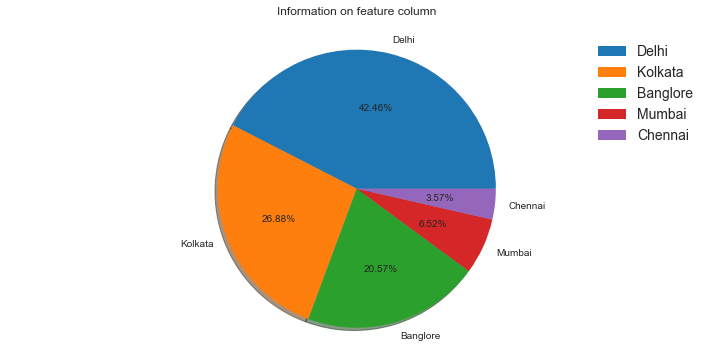

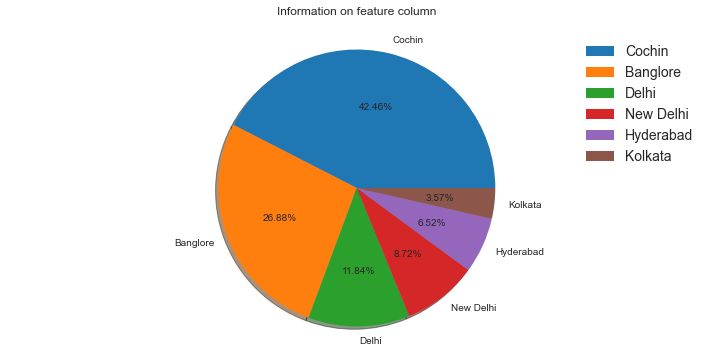

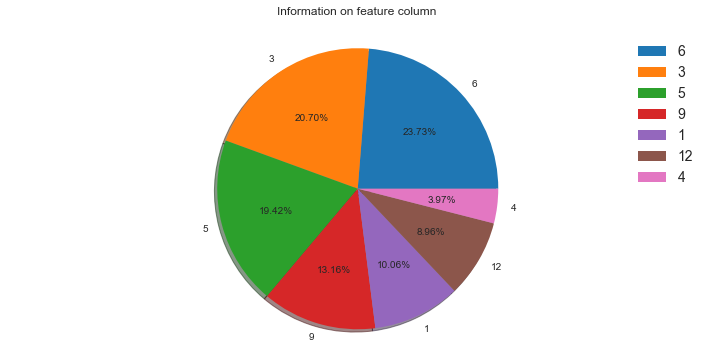

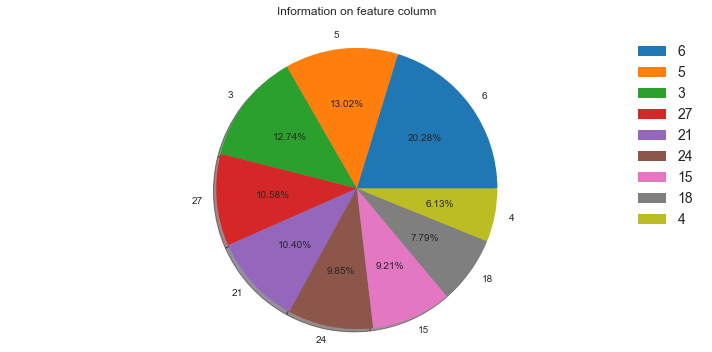

In [16]:
def generate_pie(x):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(10,5))
    plt.pie(x.value_counts(), labels=x.value_counts().index, shadow=True, autopct='%1.2f%%')
    plt.legend(prop={'size':14})
    plt.axis('equal')
    plt.title('Information on feature column\n')
    plt.tight_layout()
    return plt.show()

generate_pie(df_train['Source'])
generate_pie(df_train['Destination'])
generate_pie(df_train['Month_of_Journey'])
generate_pie(df_train['Day_of_Journey'])

from the above pie chart we have following informations:
1.in the source  , largest number of rows are covered by Delhi and lowest number of rows are covered by chennai.
2.in the destination column, highest number of rows are covered by coachin and lowest numberof rows are covered by kolkata.
3.we can see in our dataset most of the journey were made in the month of june and less journy made in the month of april.\
4.we can also see that most of journey were made by 5,6 and less journey made in 4,18.

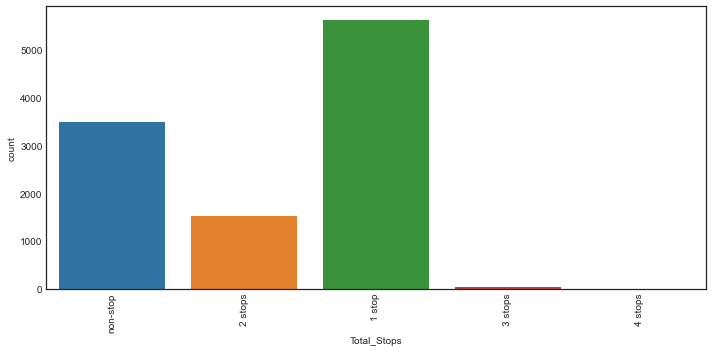

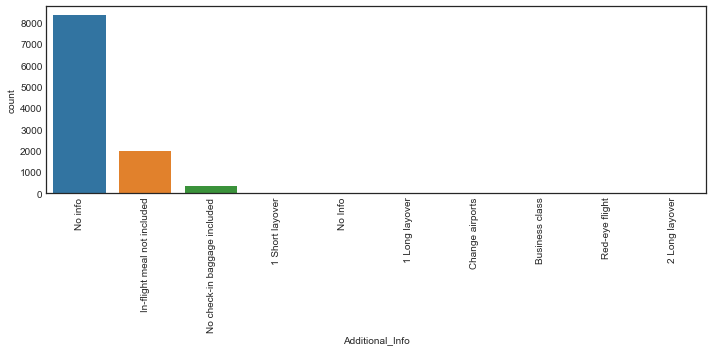

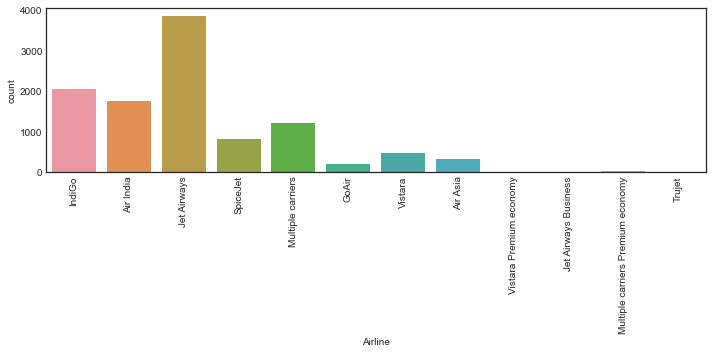

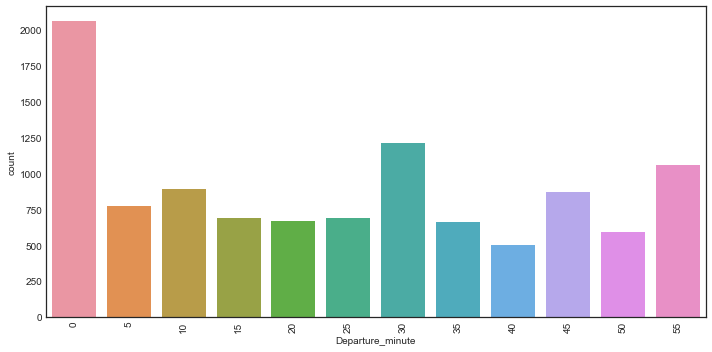

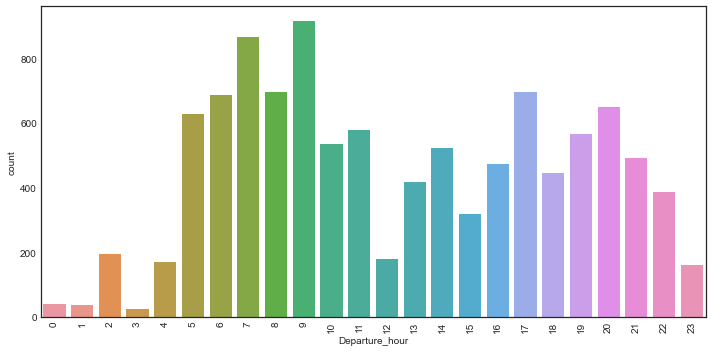

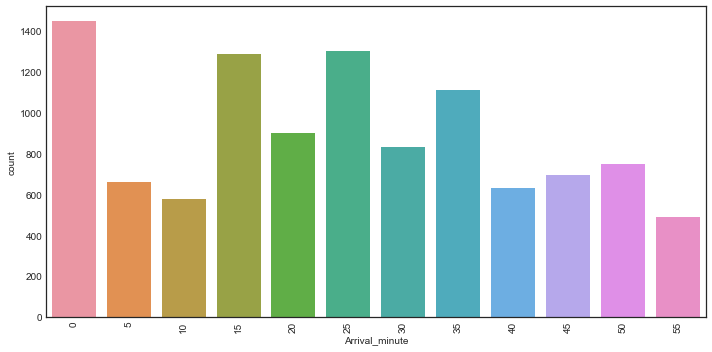

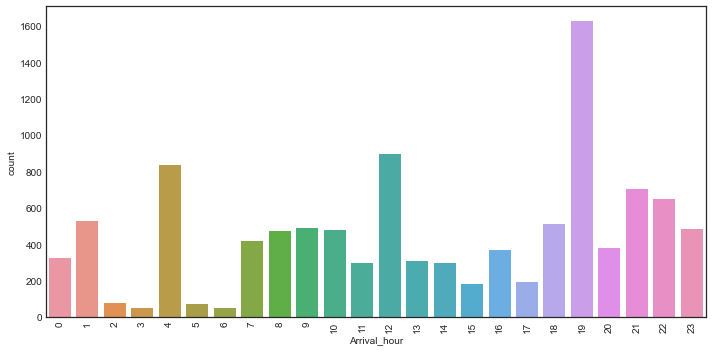

In [17]:
def generate_countplot(x):
    plt.figure(figsize=(10,5))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt.show()

generate_countplot(df_train['Total_Stops'])
generate_countplot(df_train['Additional_Info'])
generate_countplot(df_train['Airline'])
generate_countplot(df_train['Departure_minute'])
generate_countplot(df_train['Departure_hour'])
generate_countplot(df_train['Arrival_minute'])
generate_countplot(df_train['Arrival_hour'])

we have created the function for countplot and we have some information for some columns
1.in the total stops columns highest rows are covered by 1 stop and least are 3 to 4 stop.
2.In additional information column most number of rows are covered by no info values and rest of the values cover very less to negligible data points
3.The airline column shows that highest number of flight details are present in our dataset for Jet Airways followed by Indigo and Air India
4.The departure minute column gives us the indication that most number of flights get scheduled at 0 minutes for departure
5.The departure hour column gives us the indication that most number of flights get scheduled at 7 and 9 hour morning time and then there is a spike at 17 and 20 hour evening time
6.The arrival minute column gives us the indication that most number of flights get scheduled at 0 minutes for arrival
7.The arrival hour column gives us the indication that most number of flights get scheduled at 19 hour in the evening and then the chosen option for arrivals are 12 in the noon or 4 in the night

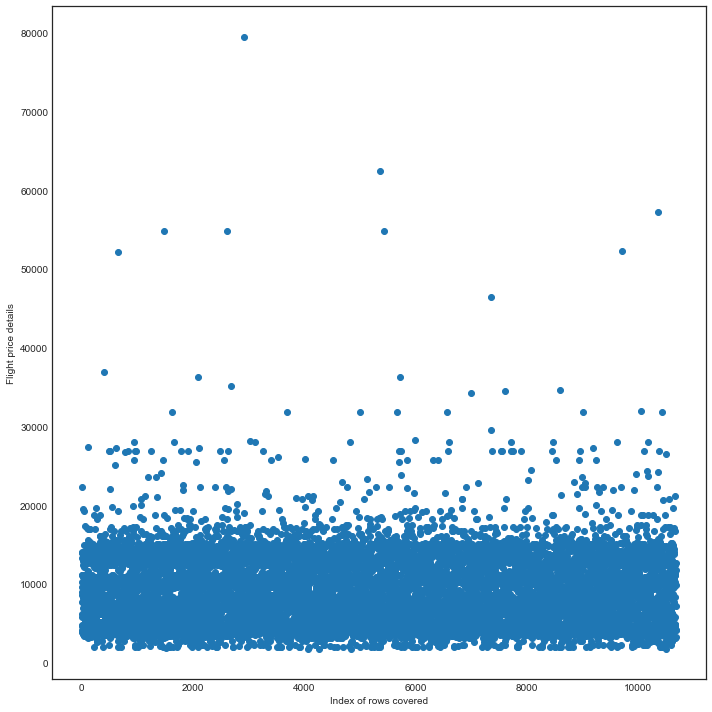

In [18]:
plt.style.use('fast')
plt.figure(figsize=(10,10))
plt.scatter(df_train.index, df_train['Price'])
plt.xlabel("Index of rows covered")
plt.ylabel("Flight price details")
plt.tight_layout()
plt.show()

n the above scatter plot we are able to see that most of the flight price values are accumulated between 0-20000 and very rare data points are distributed abov that number.

<AxesSubplot:xlabel='Source', ylabel='Price'>

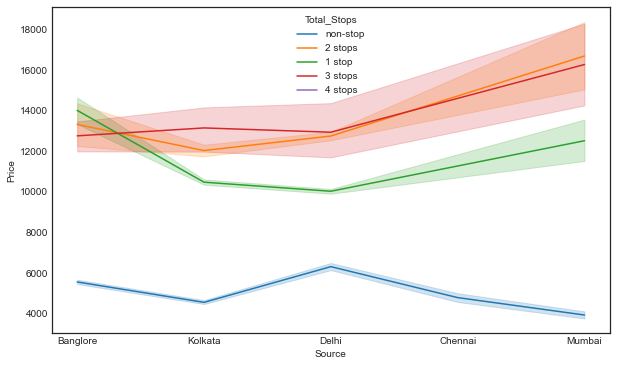

In [19]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Source', y='Price', hue='Total_Stops', data=df_train)

from the above line plot we can see that we have information that flight of 4 stop has always been less price.

<AxesSubplot:xlabel='Day_of_Journey', ylabel='Price'>

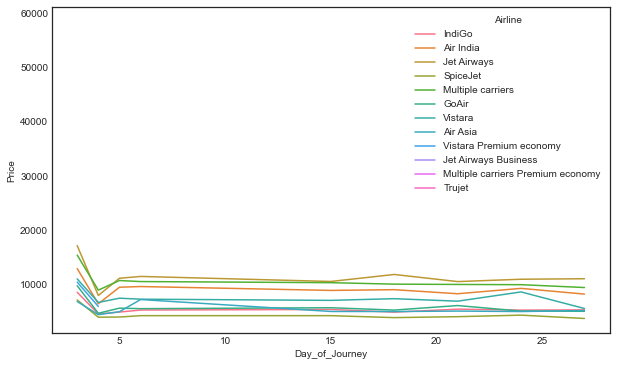

In [20]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Day_of_Journey', y='Price', hue='Airline', data=df_train, ci=None)

n the above line plot we see that all the airlines have high price between 1-5 days of a month and that reduces a bit on rest of the days apart from them.

<AxesSubplot:xlabel='Departure_minute', ylabel='Price'>

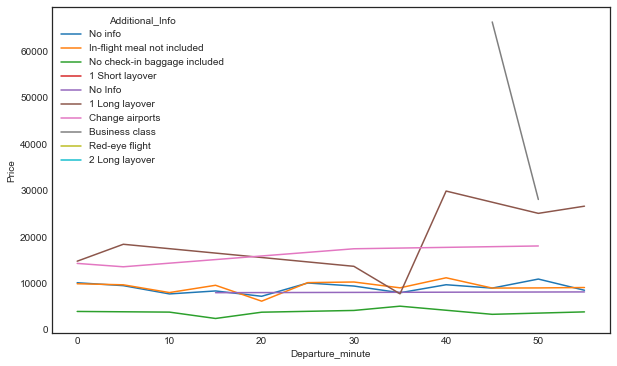

In [21]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Departure_minute', y='Price', hue='Additional_Info', data=df_train, ci=None)

In the above line plot we see that Business class has high price and has data coverage for departure minutes between 45-50 minutes roughly.

<AxesSubplot:xlabel='Departure_hour', ylabel='Price'>

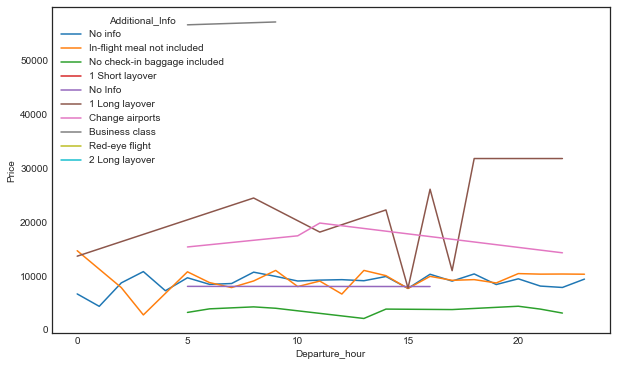

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Departure_hour', y='Price', hue='Additional_Info', data=df_train, ci=None)

In the above line plot we see that business class has high price and it's departure hour is between 5-10 but the second highest pricing is for 1 long layover type with spike in between 17-22 departure hour

<AxesSubplot:xlabel='Arrival_minute', ylabel='Price'>

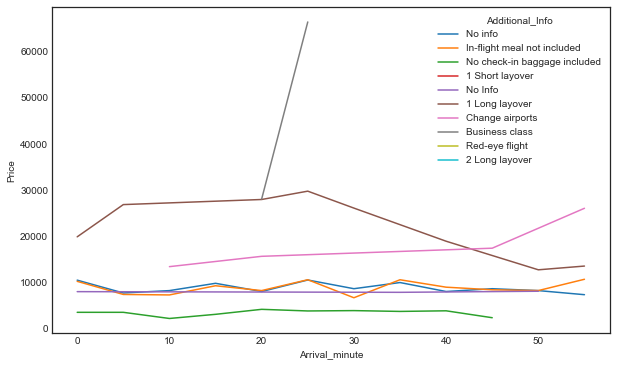

In [23]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Arrival_minute', y='Price', hue='Additional_Info', data=df_train, ci=None)

In the above line plot we see that business class again has an exponential price rise and the arrival minutes mostly range between 20-30 minutes

<AxesSubplot:xlabel='Arrival_hour', ylabel='Price'>

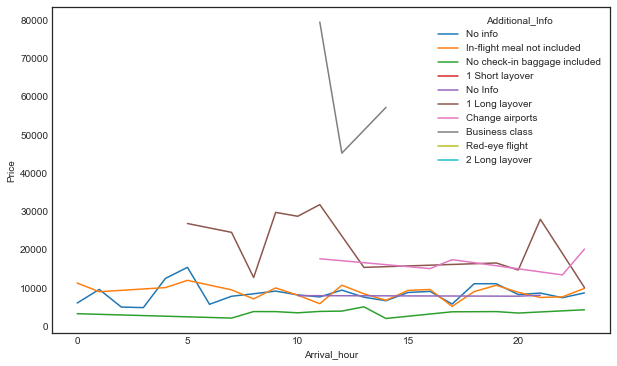

In [24]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Arrival_hour', y='Price', hue='Additional_Info', data=df_train, ci=None)

n the above line plot we see that price for no check-in bag included is least as compared to the business class being highest and the arrival hour for business class is spread only between 10-15 minutes

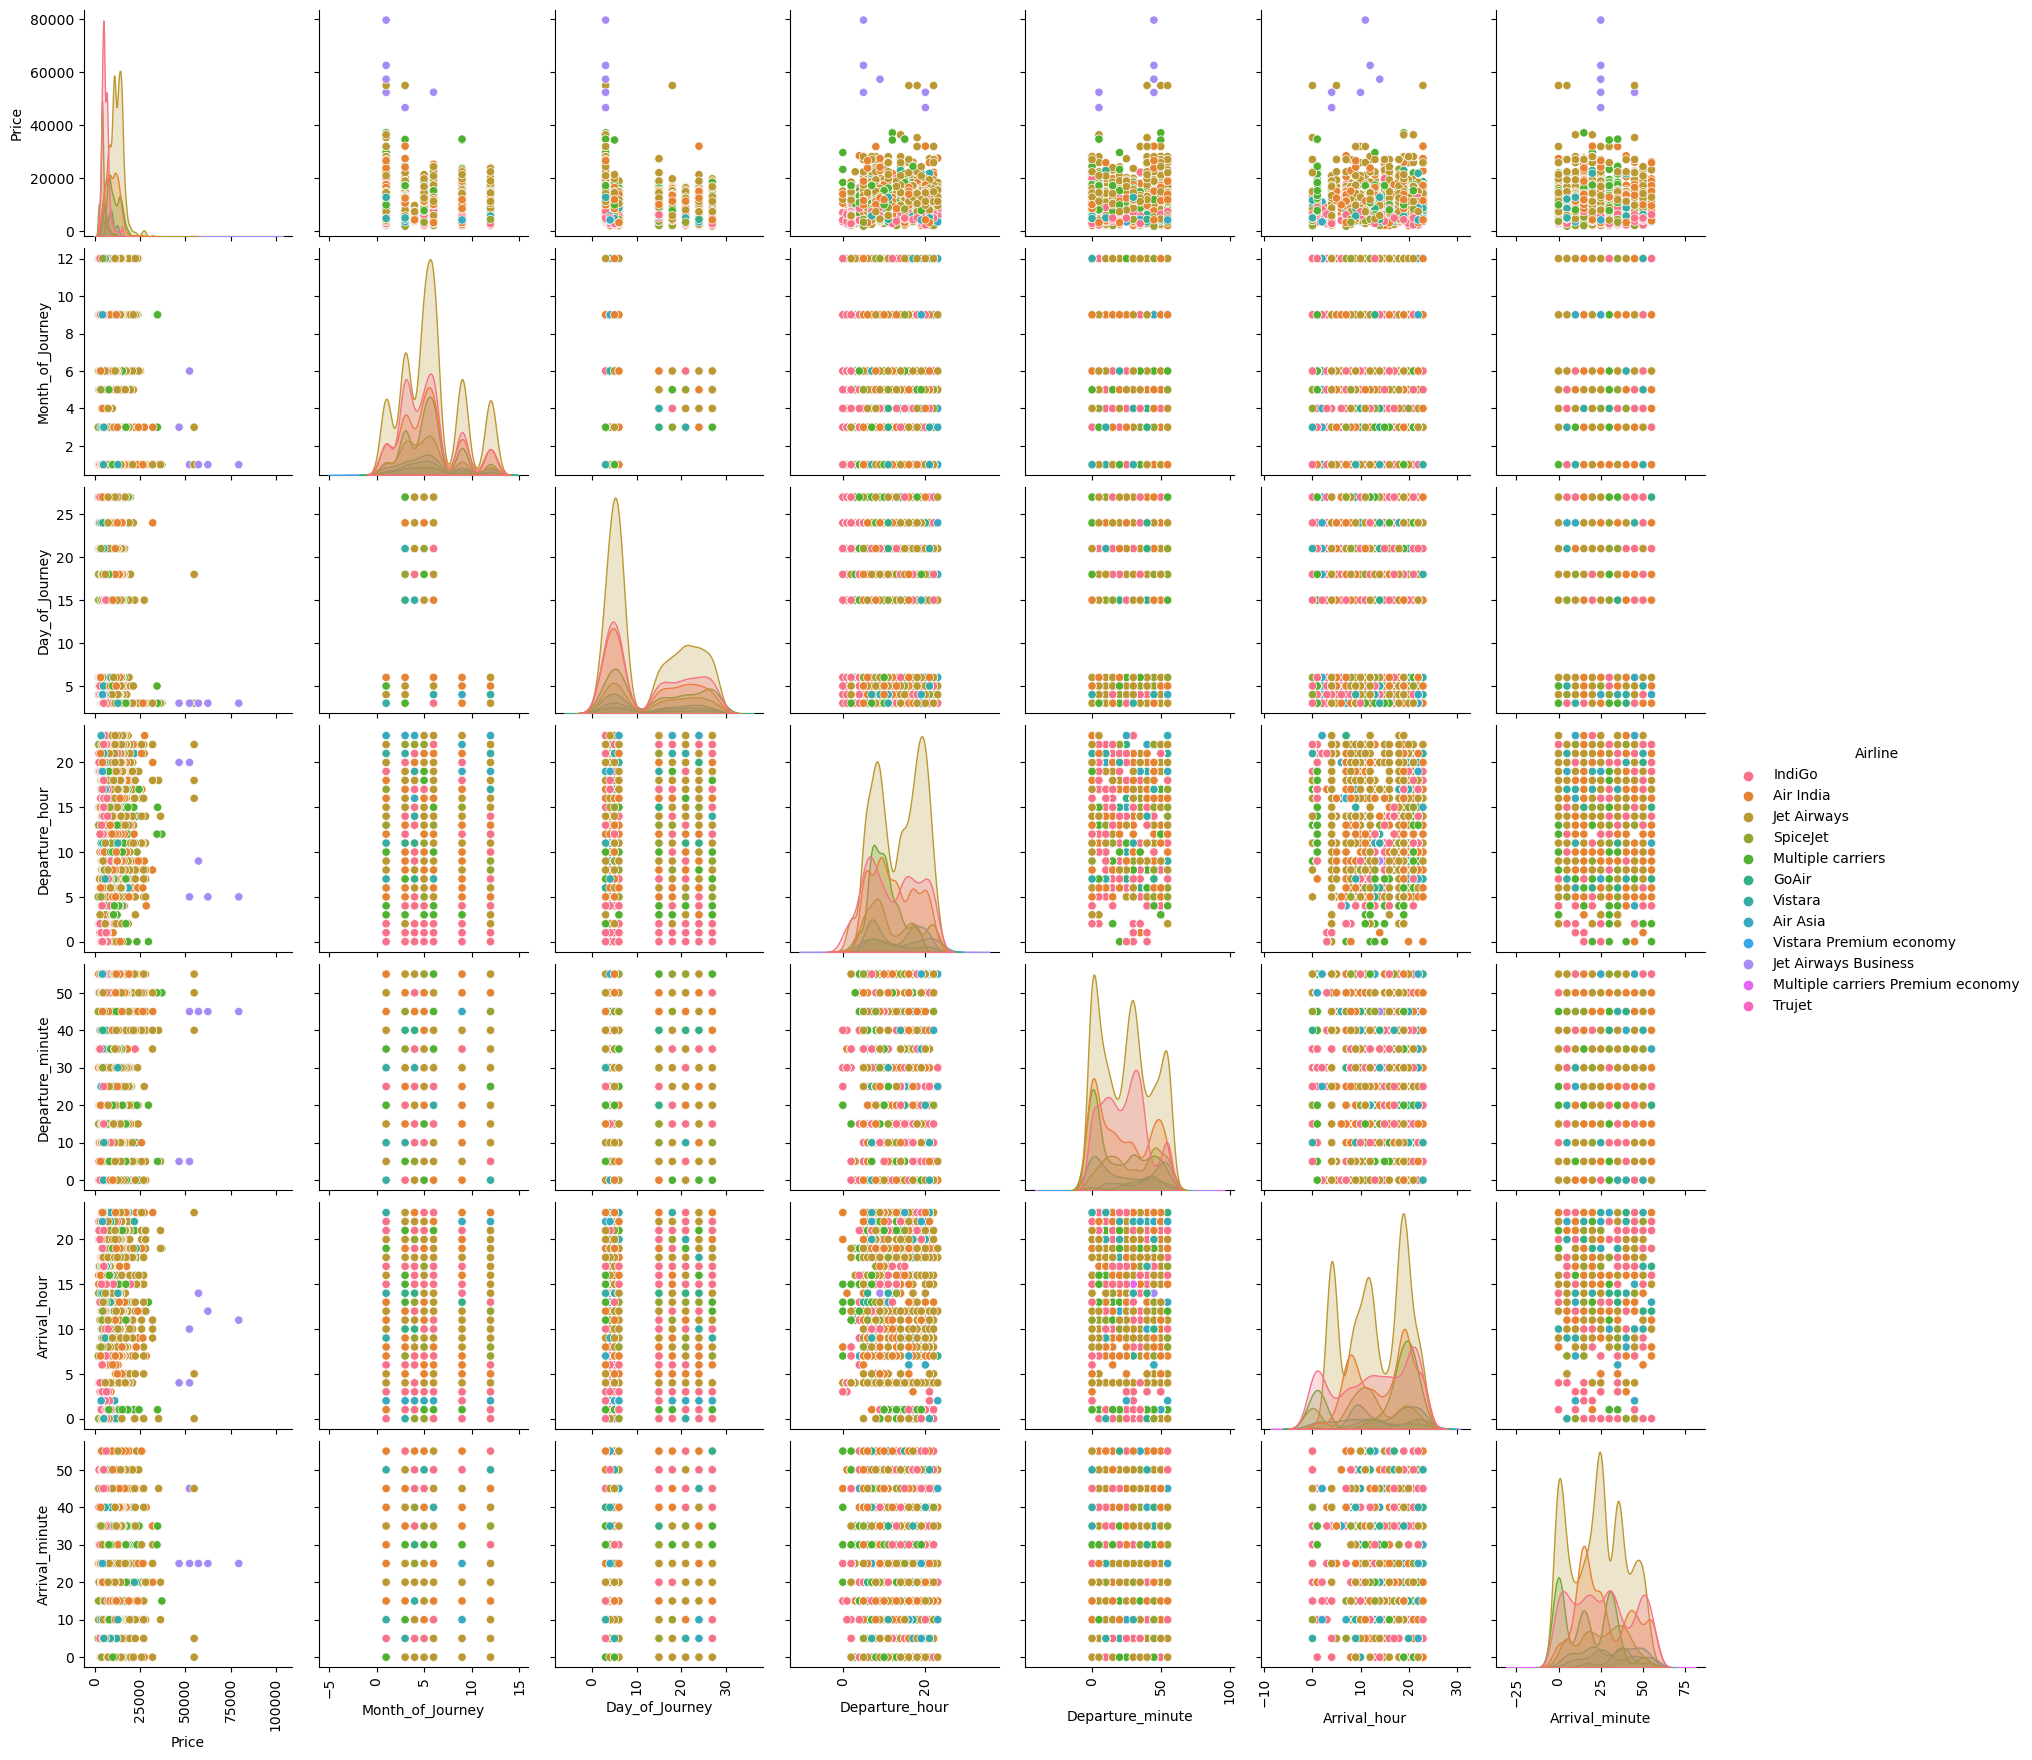

In [25]:
plt.style.use('default')
g = sns.pairplot(df_train, hue='Airline', diag_kind='kde')
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

In [26]:
oe=OrdinalEncoder()
def ordinal_encoder(df, col):
    df[col]=oe.fit_transform(df[col])
    return df

df_train=ordinal_encoder(df_train,['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info'])

we have used here ordinalEncoder to convert the object_datatype data to numerical type data.

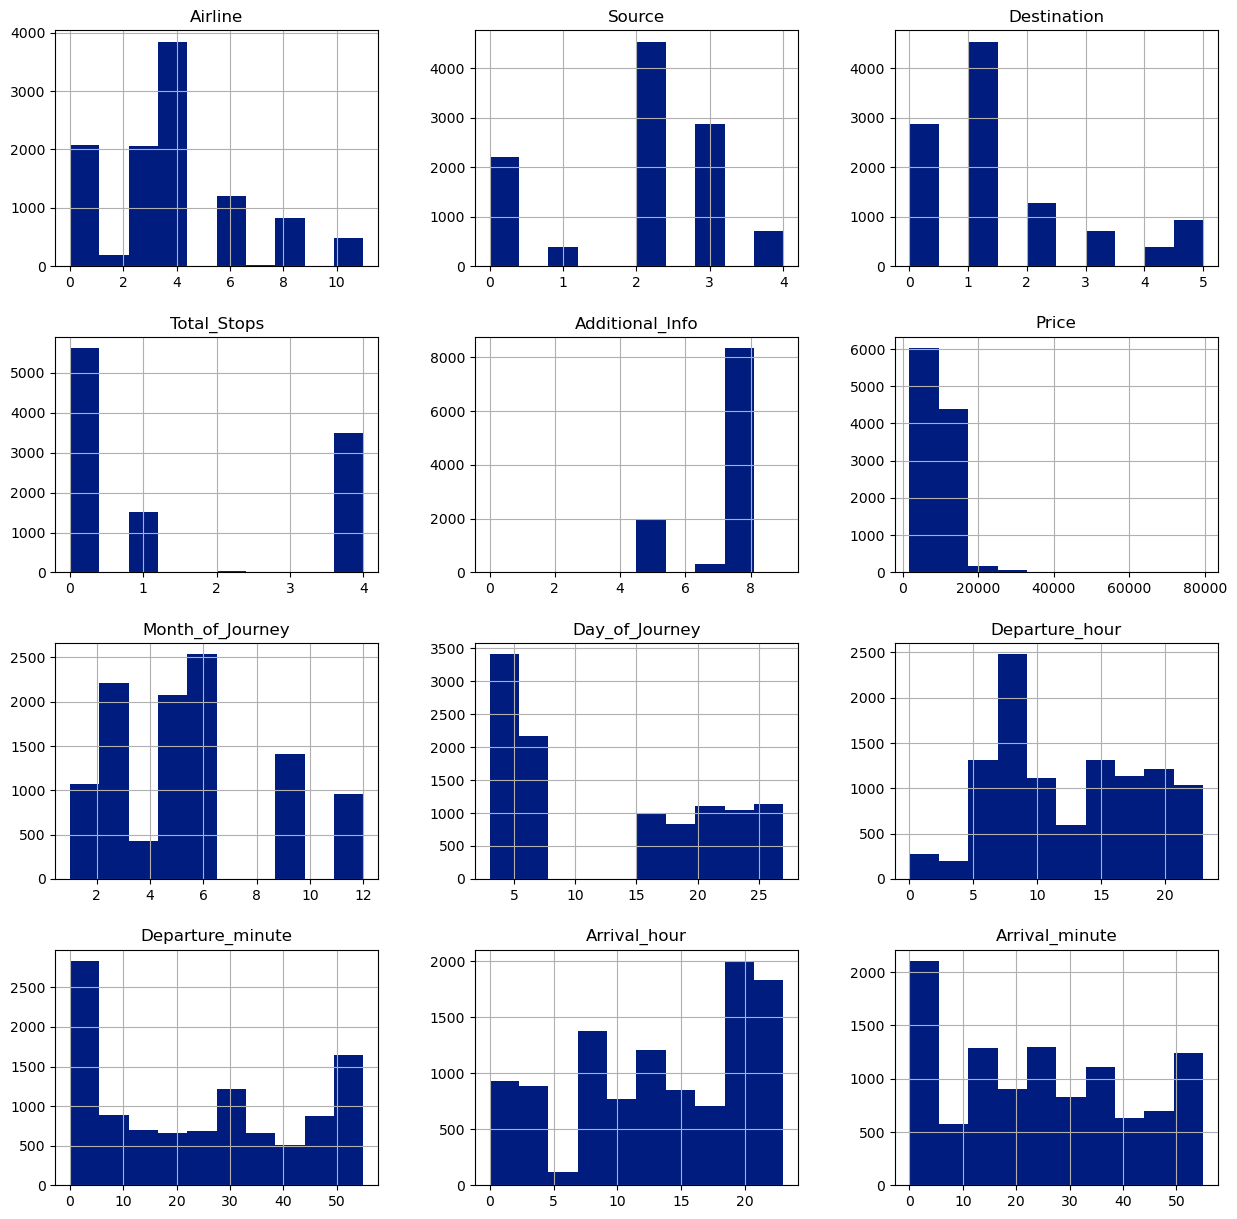

In [27]:
plt.style.use('seaborn-dark-palette')
df_train.hist(figsize=(15,15))
plt.show()


With the help of hist method we can see the distribution of data in columns after using ordialEncoder to the catagorical data.

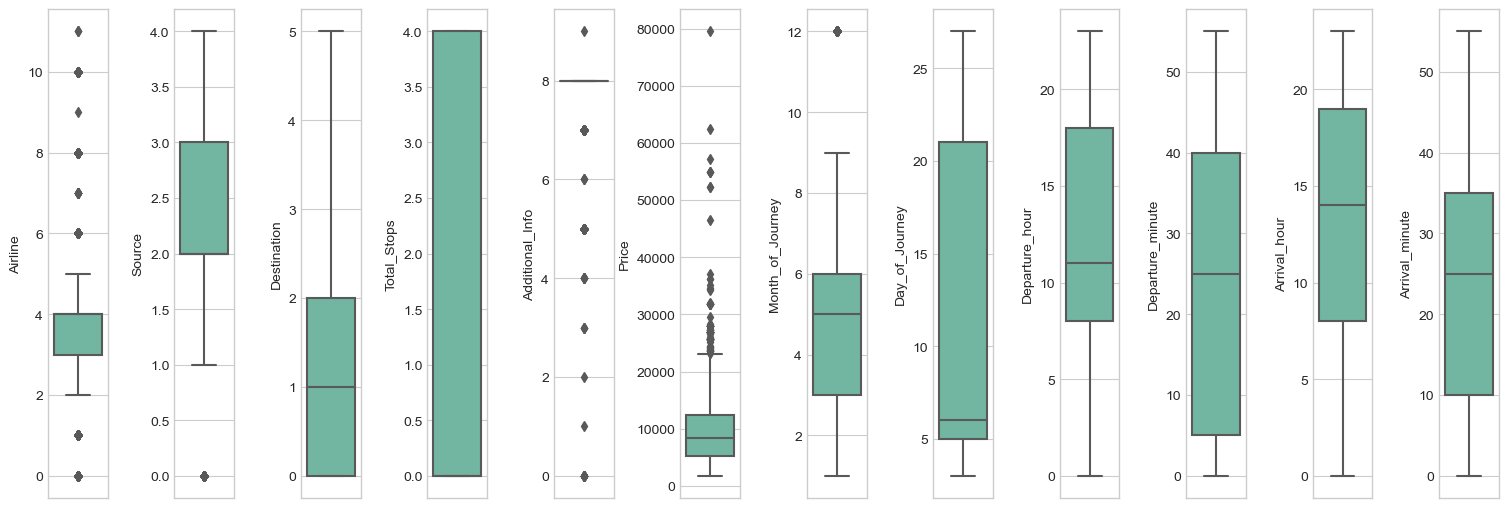

In [28]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=12, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df_train.items():
    sns.boxplot(y=col, data=df_train, ax=ax[index], palette="Set2")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

from the above box plot method  we are sure we have some outlier is present in our dataset.

ig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df_train.items():
    sns.distplot(value, ax=ax[index], hist=False, color="r", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

we removing the outlier we have only lost near 1% data from our dataset .

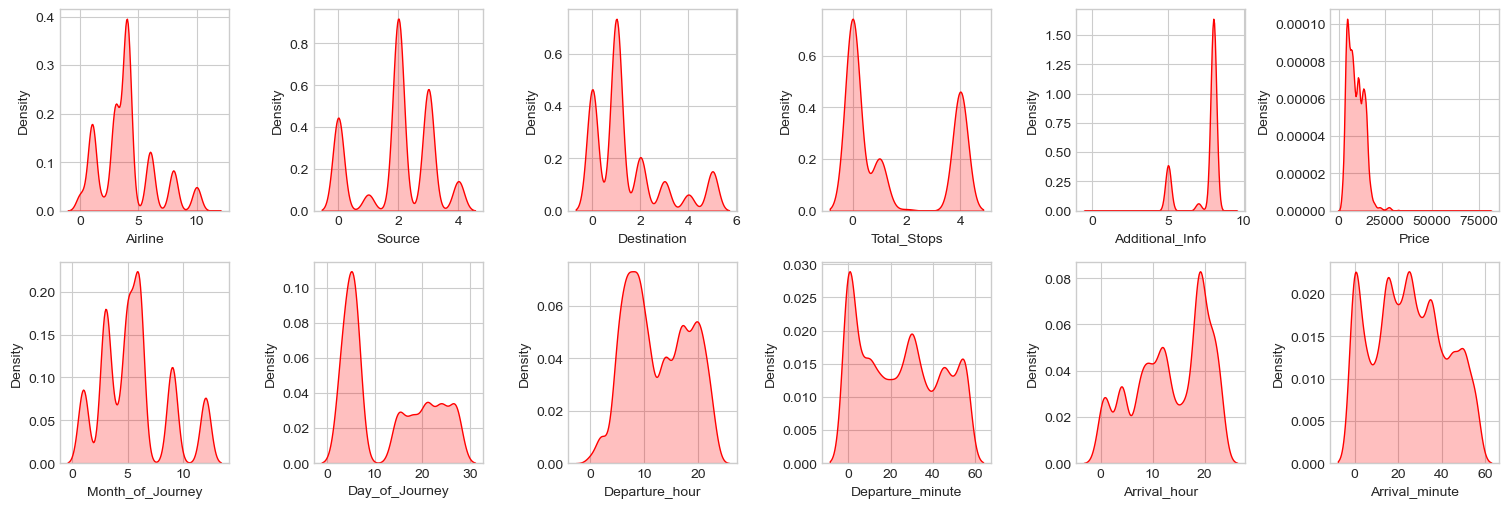

In [29]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df_train.items():
    sns.distplot(value, ax=ax[index], hist=False, color="r", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()


# Correlation using a Heatmap
Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

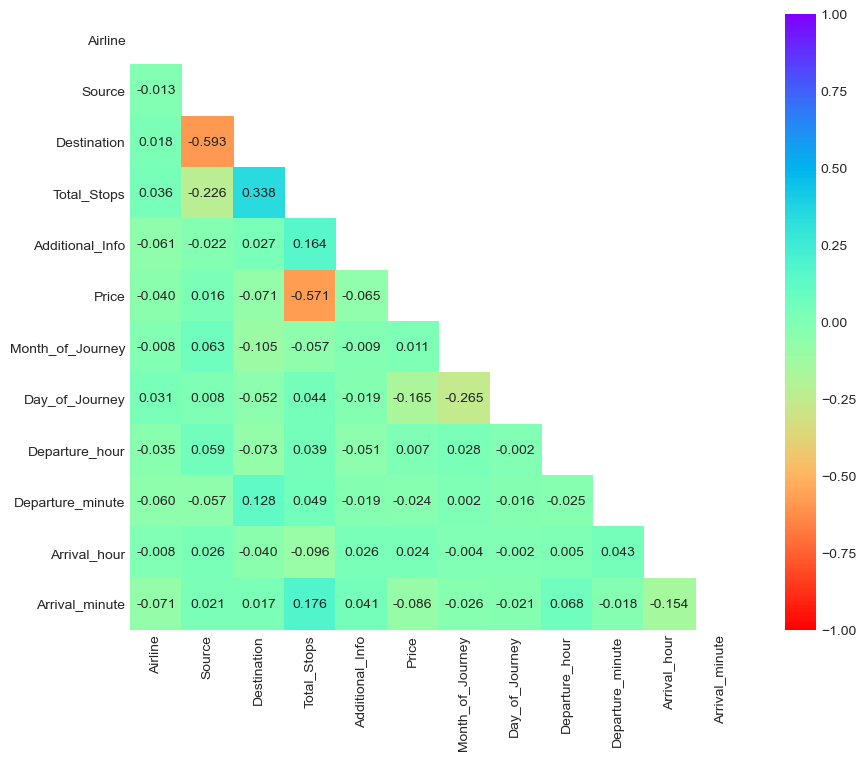

In [30]:
plt.style.use('seaborn-pastel')
upper_triangle=np.triu(df_train.corr())
plt.figure(figsize=(10,8))
sns.heatmap(df_train.corr(),vmin=-1, vmax=1, annot=True, square=True,fmt='.3f',
            annot_kws={'size':10}, cmap='rainbow_r', mask=upper_triangle)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


With the help of about heatmap we are able to notice the correlation details between our label and feature and also amongst our labels. After eye balling the above heatmap we can see that there are no multi collinearity concerns in our dataset so we won't have to worry about dealing with them.

# Correlation Bar Plot comparing features with our label

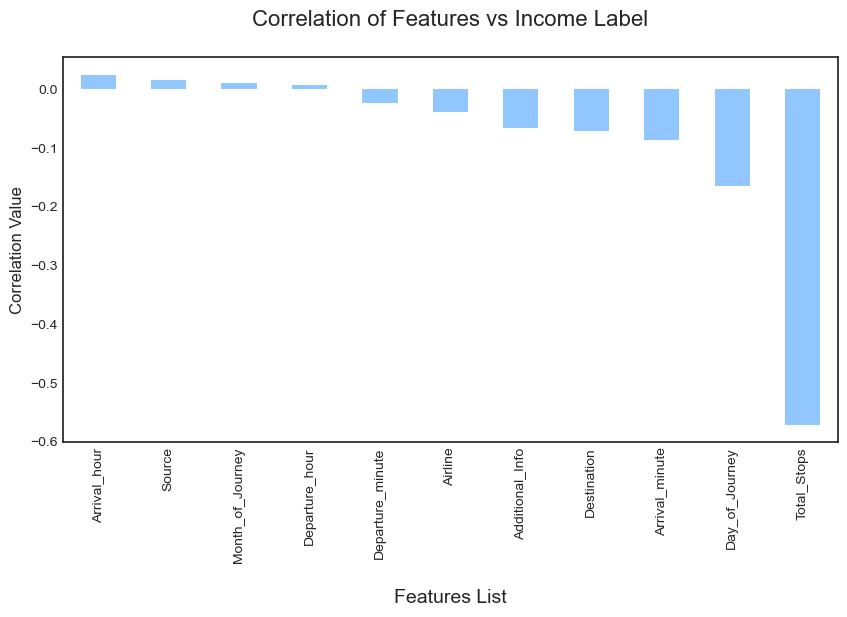

In [31]:
plt.style.use('seaborn-white')
df = df_train.corr()
plt.figure(figsize=(10,5))
df['Price'].sort_values(ascending=False).drop('Price').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

from the above plot we can see that most of the columns are negatively correlated with our target label.

# splitting whole the dataset into two parts namely X and Y

In [32]:
X=df_train.drop('Price',axis=1)
Y=df_train['Price']

In [33]:
df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
Airline,1.000000,-0.013397,0.018446,0.035973,-0.060748,-0.039565,-0.007900,0.031118,-0.035269,-0.059922,-0.007567,-0.071092
Source,-0.013397,1.000000,-0.592576,-0.225605,-0.022109,0.015999,0.063052,0.007563,0.059047,-0.056998,0.025635,0.021040
Destination,0.018446,-0.592576,1.000000,0.337872,0.026821,-0.071122,-0.105035,-0.052102,-0.072997,0.127931,-0.039729,0.017196
Total_Stops,0.035973,-0.225605,0.337872,1.000000,0.164054,-0.571221,-0.056514,0.043844,0.039224,0.048901,-0.095650,0.175980
Additional_Info,-0.060748,-0.022109,0.026821,0.164054,1.000000,-0.065463,-0.009105,-0.019416,-0.050983,-0.019392,0.026204,0.041310


# Feature Scaling

In [34]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()


,Airline,Source,Destination,Total_Stops,Additional_Info,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
0,-0.410805,-1.658359,2.416534,1.407210,0.499921,-0.848450,1.285536,1.654154,-0.234950,-1.800436,-0.890014
1,-1.261152,0.890014,-0.973812,-0.253703,0.499921,-1.517909,-0.872724,-1.303113,1.363607,-0.050909,-0.587094
2,0.014369,0.040556,-0.295743,-0.253703,0.499921,1.159928,-0.759131,-0.607286,0.031476,-1.363054,0.018745
3,-0.410805,0.890014,-0.973812,-0.807341,0.499921,2.164117,-0.872724,0.958326,-1.034229,1.407030,0.321664
4,-0.410805,-1.658359,2.416534,-0.807341,0.499921,-1.517909,-1.099909,0.610412,1.363607,1.115442,0.624584


we are using StandardScaler to normalize the whole feature columns to avoid the issue of biasness with any particular column.

# Finding best Random_State for our best Regression Model

In [35]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LinearRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(Y_test, pred)
    
    if r2>maxAccu:
        maxAccu=r2
        maxRS=i

print("Best R2 score is", maxAccu,"on Random State", maxRS)

Best R2 score is 0.41649930502295185 on Random State 503


Great we have got 114 as our best random_state value.

,Importance
Features,
Total_Stops,0.447
Airline,0.138
Day_of_Journey,0.122
Month_of_Journey,0.070
Additional_Info,0.062
Departure_hour,0.038
Arrival_hour,0.036
Departure_minute,0.030
Arrival_minute,0.024


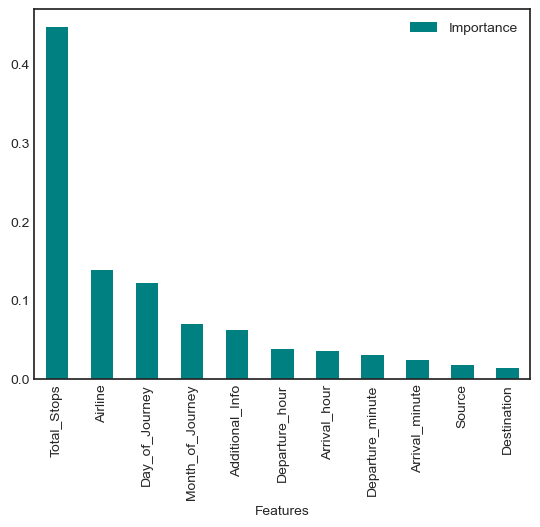

In [36]:
rf=RandomForestRegressor()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

# Machine Learning Model for Regression with evaulution matrix

In [37]:
# Regression Model Function

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=503)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv=(cross_val_score(model,X,Y,cv=5).mean())*100
    print('cv score is ', cv)
    
    # Result of r2 score minus cv score
    result = r2 - cv
    print("R2 Score - Cross Validation Score is", result)

In [38]:
#linerarRegression
model=LinearRegression()
reg(model,X,Y)

RMSE Score is: 3283.9333661247338
R2 Score is: 41.649930502295184
cv score is  36.78686137696728
R2 Score - Cross Validation Score is 4.863069125327904


In [39]:
# Ridge Regression

model=Ridge(alpha=1e-2, normalize=True)
reg(model, X, Y)

RMSE Score is: 3283.27974297523
R2 Score is: 41.67315579734343
cv score is  36.78352132406274
R2 Score - Cross Validation Score is 4.889634473280694


In [40]:
# Lasso Regression

model=Lasso(alpha=1e-2, normalize=True, max_iter=1e5)
reg(model, X, Y)

RMSE Score is: 3283.8757168459756
R2 Score is: 41.65197914915917
cv score is  36.786861187985956
R2 Score - Cross Validation Score is 4.865117961173212


In [41]:
# Support Vector Regression

model=SVR(C=1.0, epsilon=0.2, kernel='poly', gamma='auto')
reg(model, X, Y)

RMSE Score is: 4225.143412434775
R2 Score is: 3.409233096218167
cv score is  2.1561287639593263
R2 Score - Cross Validation Score is 1.2531043322588409


In [42]:
# Decision Tree Regressor

model=DecisionTreeRegressor(criterion="poisson", random_state=111)
reg(model, X, Y)

RMSE Score is: 3163.8152442072924
R2 Score is: 45.84046417539799
cv score is  59.91536240657229
R2 Score - Cross Validation Score is -14.074898231174302


In [43]:
# Random Forest Regressor

model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 3057.5253428030182
R2 Score is: 49.418368199651844
cv score is  44.28615341315199
R2 Score - Cross Validation Score is 5.132214786499851


In [44]:
# K Neighbors Regressor

KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 3063.041082304112
R2 Score is: 49.235706258915904
cv score is  44.08994561834734
R2 Score - Cross Validation Score is 5.145760640568561


In [45]:
# Ada Boost Regressor

model=AdaBoostRegressor(n_estimators=300, learning_rate=1.05, random_state=42)
reg(model, X, Y)

RMSE Score is: 3589.677757564173
R2 Score is: 30.27899588689217
cv score is  38.01670248344135
R2 Score - Cross Validation Score is -7.737706596549181


In [46]:
# Extra Trees Regressor

model=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
reg(model, X, Y)

RMSE Score is: 1440.700043608564
R2 Score is: 88.76948056799692
cv score is  87.18815455891055
R2 Score - Cross Validation Score is 1.581326009086368


In [47]:
# XGB Regressor

model=XGBRegressor()
reg(model, X, Y)

RMSE Score is: 1346.667954738171
R2 Score is: 90.18763360203906
cv score is  89.55784902315528
R2 Score - Cross Validation Score is 0.6297845788837719


In [48]:
# LGBM Regressor

model=LGBMRegressor()
reg(model, X, Y)

RMSE Score is: 1407.2198574876352
R2 Score is: 89.28538390742678
cv score is  86.61916534266722
R2 Score - Cross Validation Score is 2.6662185647595606


# Hyper Parameter Tuning on Best Regression Model

In [49]:
# Choosing XGB Regressor

fmod_param = {'booster' : ['gbtree','dart','gblinear'],
              'importance_type' : ['gain','split'],
              'n_estimators' : [100,200,500],
              'eta' : [0.001, 0.01, 0.1]
             }

In [50]:
GSCV = GridSearchCV(XGBRegressor(), fmod_param, cv=5)

In [51]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [52]:
 GSCV.best_params_

{'booster': 'gbtree',
 'eta': 0.1,
 'importance_type': 'gain',
 'n_estimators': 500}

In [53]:
Final_Model = XGBRegressor(booster='dart', eta=0.1, importance_type='gain', n_estimatorsl =500)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred)*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: 88.09890572545874


# Saving the best ML Regression Model

In [54]:
filename = "FinalModel_E07.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_E07.pkl']

# Loading the Testing Data

In [56]:
df_test=pd.read_excel('Test_set.xlsx')

In [57]:
df_test.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [58]:
df_test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [59]:
print(f"Rows and Columns before dropping duplicates: ", df_test.shape)
df_test.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df_test.shape)

Rows and Columns before dropping duplicates:  (2671, 10)
Rows and Columns after dropping duplicates:  (2645, 10)


In [60]:
df_test = date_bifurcation(df_test)
print(f"Rows and Columns:", df_test.shape)
df_test.head()

Rows and Columns: (2645, 10)


,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Year_of_Journey,Month_of_Journey,Day_of_Journey
0,Jet Airways,Delhi,Cochin,17:30,04:25 07 Jun,1 stop,No info,2019,6,6
1,IndiGo,Kolkata,Banglore,06:20,10:20,1 stop,No info,2019,12,5
2,Jet Airways,Delhi,Cochin,19:15,19:00 22 May,1 stop,In-flight meal not included,2019,5,21
3,Multiple carriers,Delhi,Cochin,08:00,21:00,1 stop,No info,2019,5,21
4,Air Asia,Banglore,Delhi,23:55,02:45 25 Jun,non-stop,No info,2019,6,24


In [61]:
df_test = time_bifurcation(df_test)
print(f"Rows and Columns:", df_test.shape)
df_test.head()

Rows and Columns: (2645, 12)


,Airline,Source,Destination,Total_Stops,Additional_Info,Year_of_Journey,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
0,Jet Airways,Delhi,Cochin,1 stop,No info,2019,6,6,17,30,4,25
1,IndiGo,Kolkata,Banglore,1 stop,No info,2019,12,5,6,20,10,20
2,Jet Airways,Delhi,Cochin,1 stop,In-flight meal not included,2019,5,21,19,15,19,0
3,Multiple carriers,Delhi,Cochin,1 stop,No info,2019,5,21,8,0,21,0
4,Air Asia,Banglore,Delhi,non-stop,No info,2019,6,24,23,55,2,45


Using the time_bifurcation function we are separating time related values and creating additional columns from them.

In [62]:
df_test.drop("Year_of_Journey", axis=1, inplace=True)
df_test=ordinal_encoder(df_test, ['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info'])

we have used ordinalEncoder in order to convert all catagorical columns into numearical form 

In [63]:
df_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)

to avoid the Biasness to any particular columns we have use standardScaler

In [64]:
predited_values = Final_Model.predict(df_test)
data = pd.DataFrame(predited_values, columns=['Predicted Flight Prices'])
data

,Predicted Flight Prices
0,14099.586914
1,4561.408203
2,12483.493164
3,10550.769531
4,3920.036621
...,...
2640,10133.734375
2641,4790.430176
2642,16345.429688
2643,12242.818359
